**Last updated 02/20/2025**

In [2]:
!python --version

Python 3.12.5


# Ecozones

This term comes from [Malambo et al. 2021](https://www.sciencedirect.com/science/article/pii/S0034425721004314) where the authors compare ICESat-2 ATL08 processing algorithms. "Ecozone" is just a recoined term for "ecoregion" from the [RESOLVE](https://www.resolve.ngo/projects/ecoregions-world) team's 2017 global ecoregion classification https://ecoregions.appspot.com/ with 846 classes (polygons, not gridded). Available as a GEE dataset and they host a zipped shapefile (150mb) on a Google cloud.

It should be noted that this is different than the EPA's ecoregions https://www.epa.gov/eco-research/ecoregions that contains some older 2012 classifications.

##### Here, we will use the Google Earth Engine (GEE) [ee package](https://developers.google.com/earth-engine/guides/python_install) to spatially query and subset this ecozone catalog on demand and load data in as GeoPandas objects.

> [!NOTE]
> Loading in the entire dataset on demand is inefficient. There are ways to make this faster, but we just want to focus on spatial searches for now

In [7]:
import geopandas as gpd
from shapely.geometry import mapping
import ee
import geemap # https://geemap.org/installation/#install-from-conda-forge
import contextily as ctx
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
try:
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
except Exception as e:
    print(e)
    auth_msg = 'Authentication failed. Please authenticate at https://developers.google.com/earth-engine/apidocs/ee-authenticate'
    print(auth_msg)

In [ ]:
# let's define an area of interest to work with
# i chose Colorado arbitrarily
aoi = gpd.read_file(
    "https://raw.githubusercontent.com/unitedstates/districts/refs/heads/gh-pages/states/CO/shape.geojson"
)
print("Original number of vertices:", aoi.count_coordinates().iloc[0])
# and let's simplify our geometry to make the ecozone search faster
aoi = aoi.simplify(0.01)
print("Simplified number of vertices:", aoi.count_coordinates().iloc[0])

Original number of vertices: 260
Simplified number of vertices: 7


In [8]:
# define the feature collection for the GEE catalog
feature_collection = ee.FeatureCollection("RESOLVE/ECOREGIONS/2017")

In [ ]:
# reformat our search geometry
# ee expects a different geometry type than shapely geometries we're accustomed to in geopandas
ee_geom_search = ee.Geometry(mapping(aoi.geometry.iloc[0]))
print(f"GEE search geom type: {type(ee_geom_search)}")

GEE search geom type: <class 'ee.geometry.Geometry'>


##### Basic spatial searches

We can utilize the `.filterBounds()` method from ee to conduct basic spatial searches

In [ ]:
# filter the catalog with our search geometry
filtered_fc = feature_collection.filterBounds(ee_geom_search)

In [28]:
# convert to a GeoDataFrame
geojson_ecozone = geemap.ee_to_geojson(filtered_fc)
# an initial define projection of "EPSG:4326" is required before reprojecting
gf_ecozone = gpd.GeoDataFrame.from_features(geojson_ecozone, crs="EPSG:4326")

In [ ]:
# since we're in CO, we only have 4 different biomes
gf_ecozone

,geometry,BIOME_NAME,BIOME_NUM,COLOR,COLOR_BIO,COLOR_NNH,ECO_BIOME_,ECO_ID,ECO_NAME,LICENSE,NNH,NNH_NAME,OBJECTID,REALM,SHAPE_AREA,SHAPE_LENG
0,"MULTIPOLYGON (((-109.61989 37.84098, -109.6198...",Temperate Conifer Forests,5,#6C9B53,#458970,#F9A91B,NE05,353,Colorado Rockies forests,CC-BY 4.0,3,Nature Could Recover,175,Nearctic,15.113154,58.146210
1,"POLYGON ((-106.73286 34.10267, -106.73236 34.0...","Temperate Grasslands, Savannas & Shrublands",8,#E7BD33,#FEFF73,#7BC141,NE08,402,Western shortgrass prairie,CC-BY 4.0,2,Nature Could Reach Half Protected,796,Nearctic,49.311356,74.175274
2,"POLYGON ((-106.66946 34.27011, -106.66713 34.2...",Deserts & Xeric Shrublands,13,#FF7F7E,#CC6767,#7BC141,NE13,429,Colorado Plateau shrublands,CC-BY 4.0,2,Nature Could Reach Half Protected,174,Nearctic,28.732790,95.122750
3,"POLYGON ((-111.44813 42.30819, -111.44547 42.3...",Deserts & Xeric Shrublands,13,#B57C47,#CC6767,#7BC141,NE13,438,Wyoming Basin shrub steppe,CC-BY 4.0,2,Nature Could Reach Half Protected,802,Nearctic,14.520123,39.080210


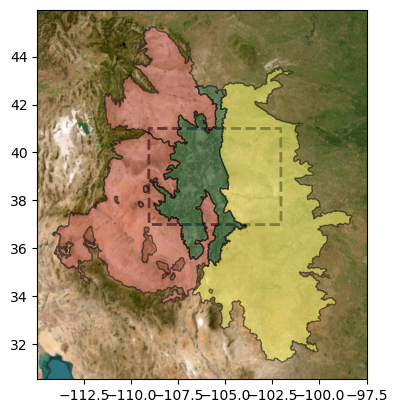

In [58]:
f, ax = plt.subplots()
aoi.plot(ax=ax, facecolor='none', edgecolor='k', linestyle='--', linewidth=2)
gf_ecozone.plot(ax=ax, color=gf_ecozone.COLOR_BIO, edgecolor='k', alpha=0.5)
ctx.add_basemap(ax, crs=aoi.crs, 
                source=ctx.providers.Esri.WorldImagery, attribution=False);

##### Spatial searches with geometry operations

We can utilize the `.map()` method to manipulate geometries on top of basic spatial searches

In [35]:
def clip_feature(f):
    """
    Function to clip feature geometries to aoi
    Note that we need to use 'intersection' for ee
    """
    return f.setGeometry(f.geometry().intersection(ee_geom_search))

def simplify_feature(f, tolerance=0.01):
    """
    Function to simplify feature geometries
    """
    return f.setGeometry(f.geometry().simplify(tolerance))

def chull_feature(f):
    """
    Function to chull feature geometries
    """
    return f.setGeometry(f.geometry().convexHull())

In [31]:
%time
# clip
fc_clip = feature_collection.filterBounds(ee_geom_search).map(clip_feature)
geojson_clip = geemap.ee_to_geojson(fc_clip)
gf_ecozone_clip = gpd.GeoDataFrame.from_features(geojson_clip, 
                                                 crs="EPSG:4326")

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 7.15 μs


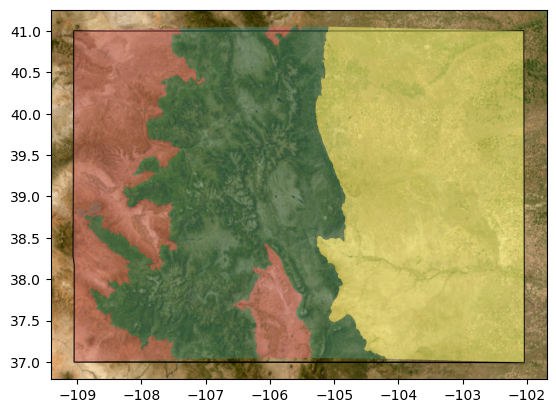

In [ ]:
# plot
# TODO: topology?
f, ax = plt.subplots()
aoi.plot(ax=ax, facecolor='none', edgecolor='k')
gf_ecozone_clip.plot(ax=ax, color=gf_ecozone_clip.COLOR_BIO, alpha=0.5)
ctx.add_basemap(ax, crs=aoi.crs, 
                source=ctx.providers.Esri.WorldImagery, attribution=False);

In [ ]:
%time
# simplify
fc_simp = feature_collection.filterBounds(ee_geom_search).map(simplify_feature)
geojson_simp = geemap.ee_to_geojson(fc_simp)
gf_ecozone_simp = gpd.GeoDataFrame.from_features(geojson_simp, 
                                                 crs="EPSG:4326")

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.77 μs


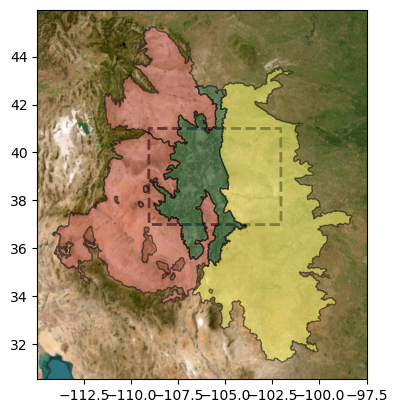

In [59]:
f, ax = plt.subplots()
aoi.plot(ax=ax, facecolor='none', edgecolor='k', linestyle='--', linewidth=2)
gf_ecozone_simp.plot(ax=ax, color=gf_ecozone_simp.COLOR_BIO, edgecolor='k', alpha=0.5)
ctx.add_basemap(ax, crs=aoi.crs, 
                source=ctx.providers.Esri.WorldImagery, attribution=False);

In [36]:
%time
# chull
fc_chull = feature_collection.filterBounds(ee_geom_search).map(chull_feature)
geojson_chull = geemap.ee_to_geojson(fc_chull)
gf_ecozone_chull = gpd.GeoDataFrame.from_features(geojson_chull, 
                                                  crs="EPSG:4326")

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 6.2 μs


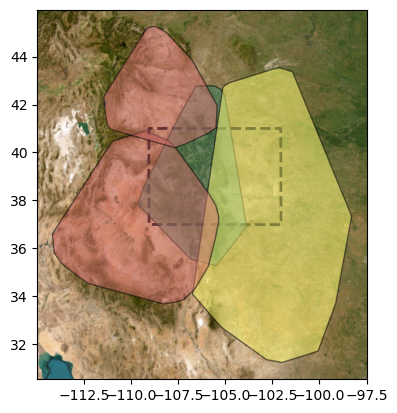

In [60]:
f, ax = plt.subplots()
aoi.plot(ax=ax, facecolor='none', edgecolor='k', linestyle='--', linewidth=2)
gf_ecozone_chull.plot(ax=ax, color=gf_ecozone_chull.COLOR_BIO, edgecolor='k', alpha=0.5)
ctx.add_basemap(ax, crs=aoi.crs, 
                source=ctx.providers.Esri.WorldImagery, attribution=False);

##### Now, let's explore ee a bit further to better understand the feature collection objects

## Understanding `ee.FeatureCollection`

### 1. `ee.FeatureCollection` Basics
An `ee.FeatureCollection` is a collection of vector features in GEE. Each feature consists of:
- **Geometry** (points, lines, or polygons)
- **Properties** (attributes associated with each geometry)

For example, the dataset **`RESOLVE/ECOREGIONS/2017`** represents terrestrial ecoregions with attributes like:
- **Biome type**
- **Ecoregion ID**
- **Protection status**
- **Remaining habitat**

More information on the dataset can be found here: https://developers.google.com/earth-engine/datasets/catalog/RESOLVE_ECOREGIONS_2017

### Common Methods on `ee.FeatureCollection`

| Method | Description |
|---------|-------------|
| `.first()` | Retrieves the first feature in the collection. |
| `.limit(n)` | Limits the collection to `n` features. |
| `.filter(ee.Filter.eq('column', value))` | Filters features based on a column value. |
| `.filterBounds(ee.geometry.Geometry)` | Filters features based on a geometry intersection. |
| `.map(function)` | Applies a function to each feature in the collection. |
| `.aggregate_sum('column')` | Sums up values in a numeric column. |
| `.aggregate_mean('column')` | Computes the mean of a numeric column. |
| `.aggregate_histogram('column')` | Creates a histogram of values in a column. |
| `.sort('column', ascending=False)` | Sorts by a column in descending order. |
| `.size()` | Returns the number of features. |

For more information on methods, refer to the ee.FeatureCollection documentation: https://developers.google.com/earth-engine/apidocs/ee-featurecollection

In [46]:
feature_collection.size().getInfo()

848

In [47]:
feature_collection.filter(ee.Filter.eq('property_name', 'value')).getInfo()

{'type': 'FeatureCollection',
 'columns': {'BIOME_NAME': 'String',
  'BIOME_NUM': 'Float',
  'COLOR': 'String',
  'COLOR_BIO': 'String',
  'COLOR_NNH': 'String',
  'ECO_BIOME_': 'String',
  'ECO_ID': 'Long',
  'ECO_NAME': 'String',
  'LICENSE': 'String',
  'NNH': 'Long',
  'NNH_NAME': 'String',
  'OBJECTID': 'Float',
  'REALM': 'String',
  'SHAPE_AREA': 'Float',
  'SHAPE_LENG': 'Float',
  'system:index': 'String'},
 'version': 1691436358500527,
 'id': 'RESOLVE/ECOREGIONS/2017',
 'properties': {'time_start': '2017-04-05T00:00:00Z',
  'time_end': '2017-04-05T00:00:00Z',
  'system:asset_size': 121908241},
 'features': []}

In [52]:
feature_collection.aggregate_mean('SHAPE_AREA').getInfo()

32.805316755774676

In [ ]:
# hmmm... what's an Element?
feature_collection.first()

### 2. `ee.Element`
An `ee.Element` is a generic class in Earth Engine, and `ee.Feature` inherits from `ee.Element`. Features are individual vector objects with geometry and properties.

### Common Methods on `ee.Element` (`ee.Feature`)

| Method | Description |
|---------|-------------|
| `.geometry()` | Returns the geometry of the feature. |
| `.get('property_name')` | Retrieves the value of a property. |
| `.set({'key': value})` | Sets a new property. |
| `.toDictionary()` | Converts the feature to a dictionary. |

In [54]:
feature_collection.first().geometry()

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Element.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Collection.first",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.loadTable",
                "arguments": {
                  "tableId": {
                    "constantValue": "RESOLVE/ECOREGIONS/2017"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [56]:
feature_collection.first().toDictionary().getInfo()

{'BIOME_NAME': 'N/A',
 'BIOME_NUM': 11,
 'COLOR': '#E2E2E0',
 'COLOR_BIO': '#FFEAAF',
 'COLOR_NNH': '#E2E2E0',
 'ECO_BIOME_': 'N/A',
 'ECO_ID': 0,
 'ECO_NAME': 'Rock and Ice',
 'LICENSE': 'CC-BY 4.0',
 'NNH': 0,
 'NNH_NAME': 'N/A',
 'OBJECTID': 207,
 'REALM': 'N/A',
 'SHAPE_AREA': 6487.84862098,
 'SHAPE_LENG': 6629.94445998}